<H1>MADATORY PYTHON LIBRARIES</H1>

In [61]:
%matplotlib  inline
import xarray
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from shapely.geometry import box, Point
plt.rcParams.update({'font.size': 15})

<h1>IN SITU GLIDERS</h1>

In Situ 'gliders' comprehends a wide range of devices that follow a predefined route submergeing every now and then in the watter column to record certain parameters. In Situ gliders produce only PR data (profiles) and its platform data type is GL.

<h1>PLOTTING PROFILES</h1>

Imagine you have downloaded some <i>_PR_ (profile)</i> dataset from In Situ gliders (see how to download files from a  certain [platform data source](https://github.com/CopernicusMarineInsitu/INSTAC-Tarining-Phase2/blob/master/PythonNotebook/In_Situ_data_download_by_platform_data_source.ipynb) or [platform category](https://github.com/CopernicusMarineInsitu/INSTAC-Tarining-Phase2/blob/master/PythonNotebooks/In_Situ_data_download_by_platform_type.ipynb)) like: [GL_PR_GL_68996.nc](ftp://nrt.cmems-du.eu/Core/INSITU_MED_NRT_OBSERVATIONS_013_035/history/profiler-glider/GL_PR_GL_68996.nc)

In [76]:
dataset = 'GL_PR_GL_68996.nc'

Let's have a look to its content:

In [77]:
full_path2file = os.getcwd()+'/'+dataset #default to current directory
print('path2file: %s'%(full_path2file))

path2file: /home/protllan/code/Training/INSTACTraining-PhaseII/PythonNotebooks/GL_PR_GL_68996.nc


In [78]:
ds = xarray.open_dataset(dataset)

ds contains all the information about the dataset (relevant metadata, variables, dimensions etc):

In [79]:
ds

<xarray.Dataset>
Dimensions:         (DEPTH: 1883, LATITUDE: 199, LONGITUDE: 199, POSITION: 199, TIME: 199)
Coordinates:
  * TIME            (TIME) datetime64[ns] 2011-01-25T17:35:40.963200 ...
  * LATITUDE        (LATITUDE) float64 0.0 39.58 39.58 39.58 39.6 39.6 39.6 ...
  * LONGITUDE       (LONGITUDE) float64 0.0 2.282 2.278 2.276 2.262 2.26 ...
Dimensions without coordinates: DEPTH, POSITION
Data variables:
    TIME_QC         (TIME) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    POSITION_QC     (POSITION) float64 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    DC_REFERENCE    (TIME) object '40453189                        ' ...
    DATA_MODE       (TIME) object 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' 'R' ...
    DIRECTION       (TIME) object 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' 'D' ...
    DATA_MODE_CORA  (TIME) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    PRES            (TIME, DEPTH) float64 15.63 15.85 16.1 16.39 16.72 17.13 ...
    PRES_QC         (TIME, DEPTH) floa

these attributes can be accesed individually; i.e:

In [80]:
ds.variables.keys()

[u'TIME',
 u'TIME_QC',
 u'LATITUDE',
 u'LONGITUDE',
 u'POSITION_QC',
 u'DC_REFERENCE',
 u'DATA_MODE',
 u'DIRECTION',
 u'DATA_MODE_CORA',
 u'PRES',
 u'PRES_QC',
 u'TEMP',
 u'TEMP_QC',
 u'PSAL',
 u'PSAL_QC',
 u'TEMP_DOXY',
 u'TEMP_DOXY_QC',
 u'CPHL',
 u'CPHL_QC',
 u'TUR4',
 u'TUR4_QC',
 u'DOX2',
 u'DOX2_QC',
 u'CNDC',
 u'CNDC_QC']

Every of the above parameters varies along certain dimensions (within parenthesis when checking the parameter metadata):

In [81]:
ds['TEMP']

<xarray.DataArray 'TEMP' (TIME: 199, DEPTH: 1883)>
[374717 values with dtype=float64]
Coordinates:
  * TIME     (TIME) datetime64[ns] 2011-01-25T17:35:40.963200 ...
Dimensions without coordinates: DEPTH
Attributes:
    long_name:      Sea temperature
    standard_name:  sea_water_temperature
    units:          degrees_C

Every of the above variables have a corresponding '_QC' variable, which is the variable that contains the data quality flags:

In [82]:
ds['TEMP_QC']

<xarray.DataArray 'TEMP_QC' (TIME: 199, DEPTH: 1883)>
[374717 values with dtype=float64]
Coordinates:
  * TIME     (TIME) datetime64[ns] 2011-01-25T17:35:40.963200 ...
Dimensions without coordinates: DEPTH
Attributes:
    long_name:      quality flag
    conventions:    OceanSITES reference table 2
    valid_min:      0
    valid_max:      9
    flag_values:    [0 1 2 3 4 5 6 7 8 9]
    flag_meanings:  no_qc_performed good_data probably_good_data bad_data_tha...

This '_QC' variable will therefore guide us when when working with the parameter data to distinguish good from bad data: 

In [83]:
pd.DataFrame(data=ds['TEMP_QC'].attrs['flag_values'], index = ds['TEMP_QC'].attrs['flag_meanings'].split(' '), columns = ['quality flag'])

,quality flag
no_qc_performed,0
good_data,1
probably_good_data,2
bad_data_that_are_potentially_correctable,3
bad_data,4
value_changed,5
not_used,6
nominal_value,7
interpolated_value,8
missing_value,9


This way, we will be able to work with good data by selecting only those values with QC flag 1:

In [122]:
good_data = ds['TEMP'].where(ds['TEMP_QC'] == 1)

Now, let's see how many profiles has been taken by this glider:

In [123]:
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=good_data.min().values.tolist(), vmax=good_data.max().values.tolist())

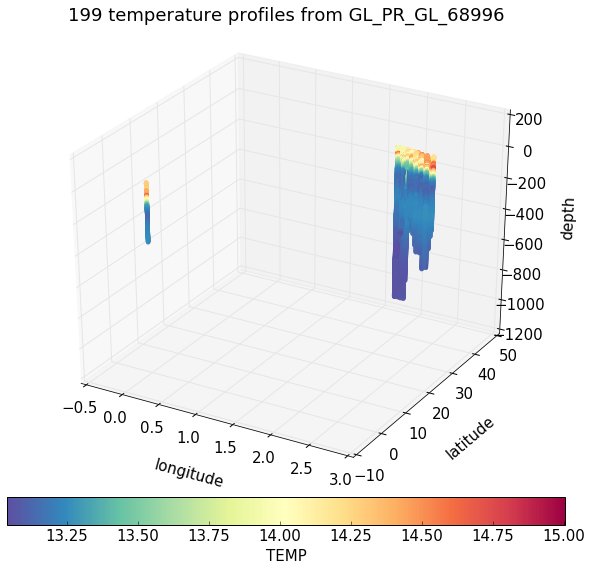

In [255]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
for a in range(0, len(ds['TIME'])):
    lat = ds['LATITUDE'].values.tolist()[a]
    lon = ds['LONGITUDE'].values.tolist()[a]    
    plt.scatter(lon*np.ones(len(ds['PRES'].values.tolist()[a])),lat*np.ones(len(ds['PRES'].values.tolist()[a])), zs=-ds['PRES'][a,:], zdir='z', s=20, c=good_data[a,:], edgecolor='None', cmap=cmap, norm=norm)
cbar = plt.colorbar(orientation="horizontal", pad=0.02)
cbar.ax.set_xlabel('TEMP')
ax.set_title(str(a+1)+' temperature profiles from '+ ds.id, y=1.08)
ax.set_zlabel('depth',labelpad=20,rotation=90)
ax.set_ylabel('latitude',labelpad=20)
ax.set_xlabel('longitude',labelpad=20)

<h1>PLOTTING AVAILABLE PROFILES IN A CERTAIN AREA</h1>

In [256]:
targeted_lon_min = 1.5
targeted_lon_max = 3
targeted_lat_min = 30
targeted_lat_max = 50
targeted_area = box(targeted_lon_min, targeted_lat_min, targeted_lon_max, targeted_lat_max)

In [257]:
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=good_data.min().values.tolist(), vmax=good_data.max().values.tolist())

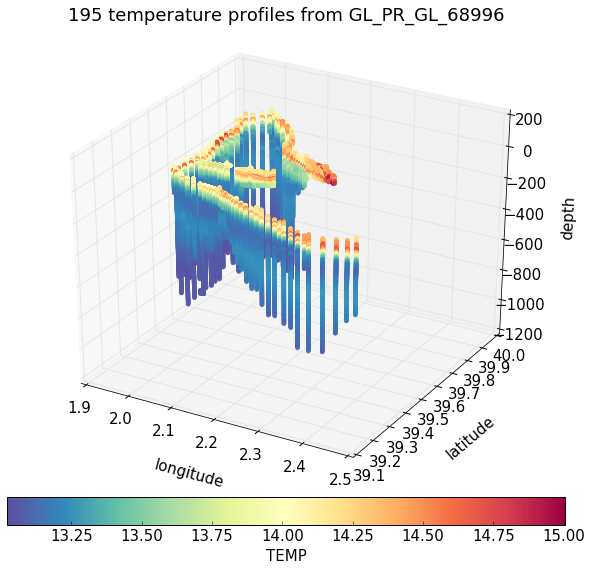

In [258]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
b=0
for a in range(0, len(ds['TIME'])):
    lat = ds['LATITUDE'].values.tolist()[a]
    lon = ds['LONGITUDE'].values.tolist()[a]
    xy_point = Point(lon,lat) # = Point(x,y)
    if targeted_area.contains(xy_point):
        b = b+1
        plt.scatter(lon*np.ones(len(ds['PRES'].values.tolist()[a])),lat*np.ones(len(ds['PRES'].values.tolist()[a])), zs=-ds['PRES'][a,:], zdir='z', s=20, c=good_data[a,:], edgecolor='None', cmap=cmap, norm=norm)
cbar = plt.colorbar(orientation="horizontal", pad=0.02)
cbar.ax.set_xlabel('TEMP')
ax.set_title(str(b)+' temperature profiles from '+ ds.id, y=1.08)
ax.set_zlabel('depth',labelpad=20,rotation=90)
ax.set_ylabel('latitude',labelpad=20)
ax.set_xlabel('longitude',labelpad=20)

<h1>PLOTTING AVAILABLE PROFILES IN A CERTAIN AREA AND TIME RANGE</h1>

In [259]:
subset = ds.sel(TIME=slice('2011-01-25', '2011-01-28'))

In [260]:
subset_good_data = subset['TEMP'].where(ds['TEMP_QC'] == 1)

In [261]:
cmap = plt.cm.Spectral_r
norm = colors.Normalize(vmin=subset_good_data.min().values.tolist(), vmax=subset_good_data.max().values.tolist())

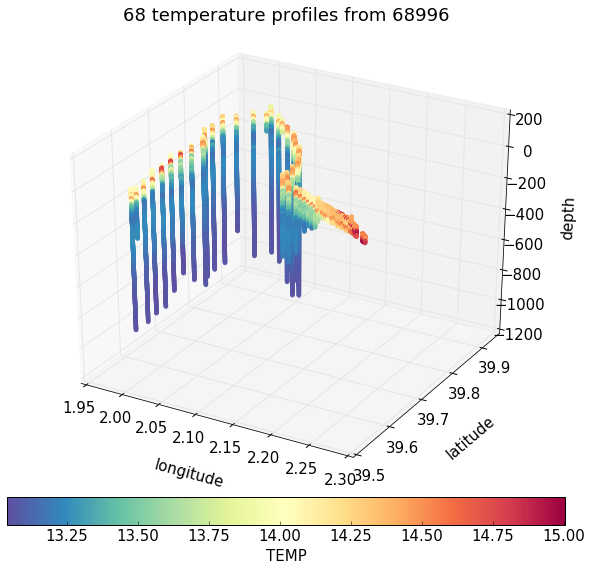

In [262]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
b=0
for a in range(0, len(subset['TIME'])):
    lat = subset['LATITUDE'].values.tolist()[a]
    lon = subset['LONGITUDE'].values.tolist()[a]   
    xy_point = Point(lon,lat) # = Point(x,y)
    if targeted_area.contains(xy_point):
        b = b+1
        plt.scatter(lon*np.ones(len(subset['PRES'].values.tolist()[a])),lat*np.ones(len(subset['PRES'].values.tolist()[a])), zs=-subset['PRES'][a,:], zdir='z', s=20, c=subset_good_data[a,:], edgecolor='None', cmap=cmap, norm=norm)
cbar = plt.colorbar(orientation="horizontal", pad=0.02)
cbar.ax.set_xlabel('TEMP')
ax.set_title(str(a+1)+' temperature profiles from '+ ds.platform_code, y=1.08)
ax.set_zlabel('depth',labelpad=20,rotation=90)
ax.set_ylabel('latitude',labelpad=20)
ax.set_xlabel('longitude',labelpad=20)